# Project Part 1

### Matthew Coleman, Romtin Toranji and Andrew Nguyen

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1a

In [7]:
data1a = np.load('part1a.npz')

In [8]:
I_c0 = data1a['Ic_0']
N = data1a['N'].sum() - I_c0.sum()
S_0 = data1a['Svc_0_pmf'].flatten()*(N.reshape(1)[0]).flatten()
R_0 = np.array([0])
t = np.linspace(0,120,120)

initial_vec = np.concatenate([S_0,I_c0,R_0])
betas = np.linspace(0.01,1,16).reshape(4,4)
gamma = data1a['gamma'].reshape(1)[0]

### 1)

In [240]:
# SIR Model

def SIR_model(t, Y, betas, gamma):
    S_vector=Y[:16].reshape(4,4)
    I_vector=Y[16:20]
    R=Y[20]
    
    # (-(-(np.sum(betas, axis = 1)*np.sum(S_vector, axis = 1)*np.sum(I_vector)))
    
    dSvc_dt= (-(betas*S_vector*np.sum(I_vector))/N)
    dIc_dt= (-np.sum(dSvc_dt, axis = 1) - gamma*I_vector).flatten()
    dR_dt= gamma*np.sum(I_vector).flatten()
    
    RHS_vector= np.concatenate([dSvc_dt.flatten(), dIc_dt, dR_dt])

    return RHS_vector

In [241]:
# Solving the initial value problem

from scipy.integrate import solve_ivp

soln_obj = solve_ivp(SIR_model, (t[0],t[-1]), initial_vec, 
                     args = (betas, gamma), dense_output = True)

In [242]:
# Calculate L's
Lc = data1a['Lc'].reshape(4,1)

L = np.sum(soln_obj.sol(t)[16:20]*Lc, axis = 0)

### 2)

Here we plot all the $S_{v,c}$ and $I_c$ values over time.

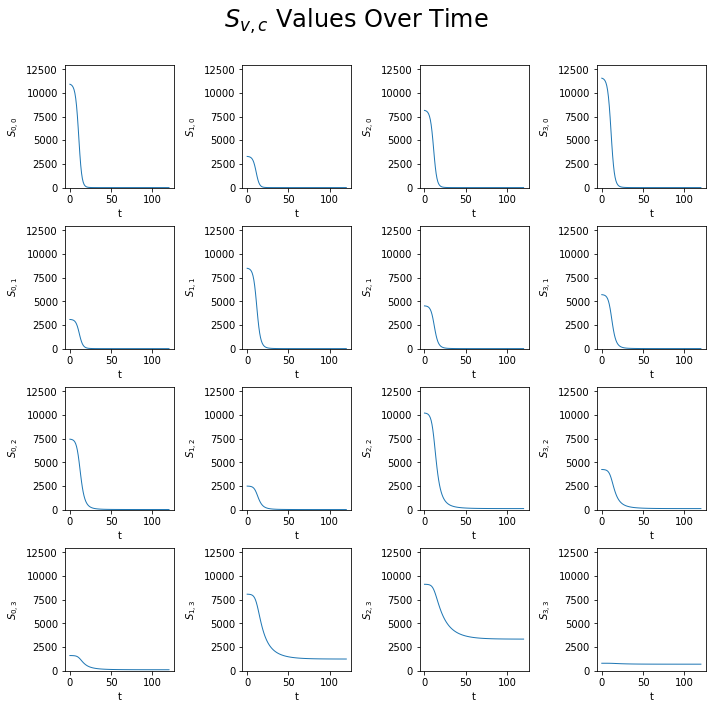

In [243]:
# S_v,c's
plt.figure(figsize=(10,10))

for i in range(0,16):
    
    plt.subplot(4,4, i+1)
    plt.ylim(-10, 13000)
    plt.plot(t, soln_obj.sol(t)[i], linewidth=1)
    plt.xlabel("t")
    plt.ylabel('$S_{{{},{}}}$'.format(i%4, i//4)).set_rotation(90)
    

plt.tight_layout()
plt.suptitle('$S_{v,c}$ Values Over Time', fontsize = 24)
plt.subplots_adjust(top=.90)
plt.show()


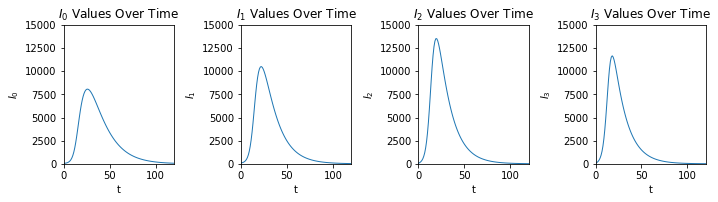

In [128]:
#I_c's over time

plt.figure(figsize=(10,10))

for i in range(0,4):
    
    plt.subplot(4,4, i+1)
    plt.xlim(0, 120)
    plt.ylim(0, 15000)
    plt.plot(t, soln_obj.sol(t)[i + 16], linewidth=1)
    plt.xlabel("t")
    plt.ylabel('$I_{}$'.format(i)).set_rotation(90)
    plt.title('$I_{}$ Values Over Time'.format(i))
    
#plt.suptitle('$I_{c}$ Values Over Time', fontsize = 20)
plt.subplots_adjust(top=.2)
plt.tight_layout()
plt.show()


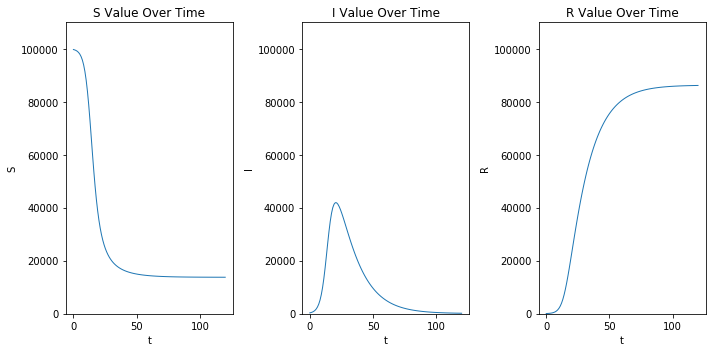

In [228]:
plt.figure(figsize=(10,5))

# S_v,c

plt.subplot(1,3,1)

plt.plot(t, np.sum(soln_obj.sol(t)[0:16], axis = 0), linewidth=1)
plt.xlabel("t")
plt.ylabel("S")
plt.ylim(-100, 110000)
plt.title('S Value Over Time')


plt.subplot(1,3,2)

# I
plt.plot(t, np.sum(soln_obj.sol(t)[16:20], axis = 0), linewidth=1)
plt.xlabel("t")
plt.ylabel("I")
plt.ylim(-100, 110000)
plt.title('I Value Over Time')


plt.subplot(1,3,3)

# R
plt.plot(t, soln_obj.sol(t)[-1], linewidth=1)
plt.xlabel("t")
plt.ylabel("R")
plt.ylim(-100, 110000)
plt.title('R Value Over Time')

plt.tight_layout()
plt.show()

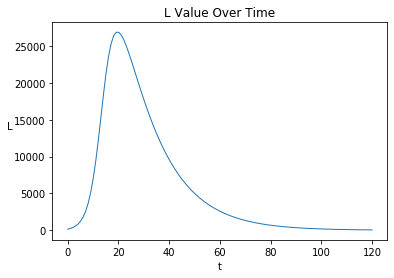

In [217]:
# L
plt.plot(t, L, linewidth=1)
plt.xlabel("t")
plt.ylabel("L").set_rotation(0)
plt.title('L Value Over Time')
plt.show()

### 3)

These plots do look like what we would expect. We would see the overall susceptible population start very close to *N*, and we would see this quickly decrease over time and then flatten out at the right tail. As *S* decreases, we would see the infected population, *I*, increase and then go back down and flatten out. As *I* increases, we would also see the viral load, *L*, increase and as *I* decreases, we would see *L* decrease. Finally, as time goes on and we see *I* go down, the number of people who have recovered, *R* would increase. The plot which is normally referred to as "flattening the curve" is the infected curve. By "flattening" the infected curve, we are able to slow the spread of the disease and prevent hospitals from being above their capacity.

### 4)

Some plots did converge to zero, while others converged to a positive value. I believe this is the case because $\beta_{v,c} = \frac{1}{Time\ between\ Contacts}$, which means that a smaller beta value would correspond to a longer time between contacts. If less people are in contact with eachother, then they are not spreading the disease as easily. This would explain why the first couple of $S_{v,c}$ plots show the curve converging to a constant. These first curves have smaller beta values while the later plots after have larger values. 

### 5)

The percentages of each population which did not get infected are below:

In [183]:
from IPython.display import display

non_infected = pd.DataFrame((soln_obj.sol(t)[0:16][:,-1]/S_0).reshape(4,4))

display(non_infected)

,0,1,2,3
0,0.886075,0.398826,0.179521,0.080811
1,0.036380,0.016380,0.007376,0.003322
2,0.001496,0.000674,0.000304,0.000137
3,0.000062,0.000028,0.000013,0.000006


### 6)

In [185]:
quarter_betas = (np.linspace(0.01,1,16).reshape(4,4))*.25

from scipy.integrate import solve_ivp

soln_obj_quart = solve_ivp(SIR_model, (t[0],t[-1]), initial_vec, 
                     args = (quarter_betas, gamma), dense_output = True)


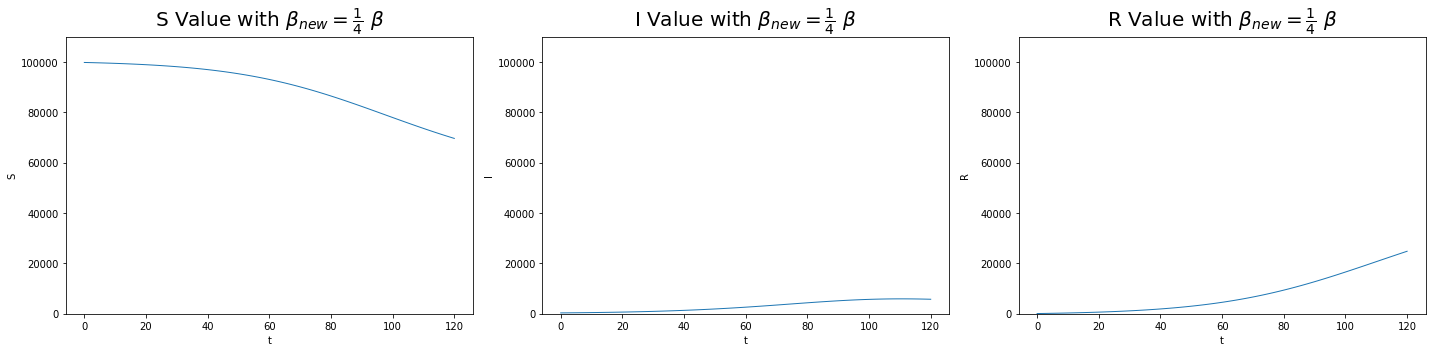

In [246]:
plt.figure(figsize=(20,5))

# S_v,c

plt.subplot(1,3,1)

plt.plot(t, np.sum(soln_obj_quart.sol(t)[0:16], axis = 0), linewidth=1)
plt.xlabel("t")
plt.ylabel("S")
plt.ylim(-100, 110000)

plt.title('S Value with $ \\beta_{new} = \\frac{1}{4}\ \\beta$', fontsize = 20)


plt.subplot(1,3,2)

# I
plt.plot(t, np.sum(soln_obj_quart.sol(t)[16:20], axis = 0), linewidth=1)
plt.xlabel("t")
plt.ylabel("I")
plt.ylim(-100, 110000)
plt.title('I Value with $ \\beta_{new} = \\frac{1}{4}\ \\beta$', fontsize = 20)


plt.subplot(1,3,3)

# R
plt.plot(t, soln_obj_quart.sol(t)[-1], linewidth=1)
plt.xlabel("t")
plt.ylabel("R")
plt.ylim(-100, 110000)
plt.title('R Value with $ \\beta_{new} = \\frac{1}{4}\ \\beta$', fontsize = 20)


plt.tight_layout()
plt.show()

As we can see from the plots above, when we scale $beta$ down, the curves do flatten, to a considerable amount. Looking at the table below, we can see the proportions of the population which were not infected at day 120.

In [237]:
non_infected = pd.DataFrame((soln_obj_quart.sol(t)[0:16][:,-1]/S_0).reshape(4,4))

display(non_infected)

,0,1,2,3
0,0.991354,0.936136,0.883994,0.834755
1,0.788259,0.744352,0.702891,0.663739
2,0.626767,0.591855,0.558887,0.527755
3,0.498357,0.470597,0.444383,0.419630


## 1b

In [3]:
data1b = np.load('part1b.npz')

### Node 1 vulnerability = .2 comobordity:(0.5,0.3,0.1,0.1)

In [138]:
## repeat this process four more times changing the values in S_0 according to the PMF of comorbodity
## can't figure out the correct MSE value. Someone please figure it out. Everything else is right

from sklearn.metrics import mean_squared_error
from scipy import integrate
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl

N = data1b["N"]

# this is the grid we will search
beta_grid=np.linspace(0,1,21)
P0_grid=np.arange(0,16)
t = np.linspace(0,19,20)
S_0 = N*[0.5,0.3,0.1,0.1]-data1b["Ic_0"][0:5]
gamma = data1b['gamma'].reshape(1)[0]

def SIR_model(t, Y, betas, gamma):
    S_vector=Y[:4].reshape(1,4)
    I_vector=Y[4:8]
    R=Y[8]
    
    # (-(-(np.sum(betas, axis = 1)*np.sum(S_vector, axis = 1)*np.sum(I_vector)))
    
    dSvc_dt= (-(betas*S_vector*np.sum(I_vector))/N)
    dIc_dt= (-dSvc_dt - gamma*I_vector).flatten()
    dR_dt= gamma*np.sum(I_vector).flatten()
    
    RHS_vector= np.concatenate([dSvc_dt.flatten(), dIc_dt, dR_dt])

    return RHS_vector

initial_vec = np.zeros((5,9))

for i in range(5):
    initial_vec[i] = (np.concatenate([S_0[i].round(),data1b['Ic_0'][i].flatten(),R_0]))

observed_data = data1b['L_validation']


mmse=np.inf
r_mmse=np.nan
K_mmse=np.nan
P0_mmse=np.nan

# we don't need to include P0_grid in the for loop,
# solve_ivp can be run for different P0 values at once
for (beta_01,beta_02,beta_03,beta_04) in product(beta_grid, beta_grid, beta_grid, beta_grid):
    if(beta_01>=beta_02 or beta_02>=beta_03 or beta_03>=beta_04):
        continue

    mse = 0
    for i in range(5):
        soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec[i], \
                                        
                                     args = (np.array([beta_01,beta_02,beta_03,beta_04]), gamma),\
                                     dense_output=True)
        solutions = soln_obj.sol(t)
        '''
        check the value below I'm not sure how to calculate it
        ''' 
        mse += mean_squared_error(observed_data[i], (data1b['Lc'].reshape(-1,4)@solutions[4:8]).flatten()) 

        #mse += (((observed_data[i]-(data1b['Lc'].reshape(-1,4)@solutions[4:8]))**2).sum())/20
  
    if(mse<mmse):
        mmse = mse
        mbeta_01 = beta_01
        mbeta_02 = beta_02
        mbeta_03 = beta_03
        mbeta_04 = beta_04
        print(mse)
    # this gets the minimum MSE over all grid points


194591.38583480843
185991.1601269793
177045.74578868414
167759.0669155929
158139.75159586838
148202.2234330444
137967.78312132217
127465.64862829336
116734.25768511221
105822.82866777385
94793.17287641735
83721.7111678454
72701.69697006649
61845.65022981221
51287.9982841556
41187.91130833818
31732.308031259672
23138.998477460045
15659.917242534457
9584.384914414592
5242.319356585015
2955.584503876439
2951.5570051589716
2708.165191950273
2455.9452398991384
2240.8264178120594
2069.752921289415
1950.3224980756709
1890.7523527262013
1812.8755100540482
1577.8956398627047
1414.0680371336246
1306.8858522525309
1275.9297960046706
1049.5258107299687
888.6297811792557
814.2470107887287
606.0536447574844
489.16838177618405
419.97828878292694
227.43888066439723
99.72834019439784
77.74873717490658
63.61714246445921
27.548455620619762


In [139]:
# print out beta estimations vs beta validation        
print(f"Estimated values for Beta: beta_01: {mbeta_01}, beta_02: {mbeta_02}, beta_03: {mbeta_03}, beta_04: {mbeta_04}")
print(f"MMSE estimate: {mmse}")


Estimated values for Beta: beta_01: 0.1, beta_02: 0.15000000000000002, beta_03: 0.2, beta_04: 0.25
MMSE estimate: 27.548455620619762


### Node 2 vulnerability = .4 comobordity:(0.4,0.3,0.2,0.1)

In [154]:
S_0 = np.outer(N-data1b["Ic_0"][5:10].sum(axis=1),[0.4,0.3,0.2,0.1])
print(N*[0.4,0.3,0.2,0.1]-data1b["Ic_0"][5:10])
print(S_0)
print(data1b["Ic_0"][5:10])

[[19965. 14969.  9922.  4989.]
 [19950. 14945.  9907.  4974.]
 [19983. 14911.  9935.  4975.]
 [19930. 14973.  9934.  4903.]
 [19980. 14982.  9968.  4969.]]
[[19938.  14953.5  9969.   4984.5]
 [19910.4 14932.8  9955.2  4977.6]
 [19921.6 14941.2  9960.8  4980.4]
 [19896.  14922.   9948.   4974. ]
 [19959.6 14969.7  9979.8  4989.9]]
[[35 31 78 11]
 [50 55 93 26]
 [17 89 65 25]
 [70 27 66 97]
 [20 18 32 31]]


In [155]:
from sklearn.metrics import mean_squared_error
from scipy import integrate
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl

S_0 = N*[0.4,0.3,0.2,0.1]-data1b["Ic_0"][5:10]

initial_vec = np.zeros((5,9))

for i in range(5):
    initial_vec[i] = (np.concatenate([S_0[i].round(),data1b['Ic_0'][i+5].flatten(),R_0]))

observed_data = data1b['L_validation'][5:10]


mmse=np.inf
r_mmse=np.nan
K_mmse=np.nan
P0_mmse=np.nan

# we don't need to include P0_grid in the for loop,
# solve_ivp can be run for different P0 values at once
for (beta_01,beta_02,beta_03,beta_04) in product(beta_grid, beta_grid, beta_grid, beta_grid):
    if(beta_01>=beta_02 or beta_02>=beta_03 or beta_03>=beta_04):
        continue

    mse = 0
    for i in range(5):
        soln_obj=0
        soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec[i], \
                                        
                                     args = (np.array([beta_01,beta_02,beta_03,beta_04]), gamma),\
                                     dense_output=True)
        solutions = soln_obj.sol(t)
        '''
        check the value below I'm not sure how to calculate it
        ''' 
        mse += mean_squared_error(observed_data[i], (data1b['Lc'].reshape(-1,4)@solutions[4:8]).flatten()) 

  
    if(mse<mmse):
        mmse = mse
        mbeta_01 = beta_01
        mbeta_02 = beta_02
        mbeta_03 = beta_03
        mbeta_04 = beta_04
        print(mse)
    # this gets the minimum MSE over all grid points
# print out beta estimations vs beta validation        
print(f"Estimated values for Beta: beta_01: {mbeta_01}, beta_02: {mbeta_02}, beta_03: {mbeta_03}, beta_04: {mbeta_04}")
print(f"MMSE estimate: {mmse}")


5929176.104801638
5856063.308961327
5777882.183751217
5694358.65261685
5605219.296324566
5510194.80264102
5409024.375500913
5301460.569262551
5187274.340555731
5066261.449011789
4938249.406878359
4803105.16604747
4660743.523292197
4511136.212363861
4354321.869685986
4190418.5908944015
4019635.100410968
3842280.6573462435
3677694.794786362
3484682.670556886
3303626.922716854
3096009.9477146366
2899752.0955054816
2679738.6725168778
2470916.816687403
2242239.2402902218
2025267.6253829263
1793582.5688548344
1575072.888915774
1348371.3438457262
1137518.560115827
926502.1990071838
735411.6621746263
554067.637910943
398140.0379570072
263321.09609829285
159964.45888002156
91228.86498351279
90228.81536896658
59894.33170283044
56886.269390545516
53509.65126688123
48464.05710461542
46387.953945427194
45143.105025420045
40909.148479924734
40101.12903579798
34535.64252034613
28856.162349966817
24171.747570839336
24114.0304530471
19920.2231144538
17706.9050716549
16509.146243758874
13938.57356662299

### Node 3 vulnerability = .6 comobordity:(0.3,0.3,0.2,0.2)

In [156]:
from sklearn.metrics import mean_squared_error
from scipy import integrate
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl

N = data1b["N"]

# this is the grid we will search
beta_grid=np.linspace(0,1,21)
P0_grid=np.arange(0,16)
t = np.linspace(0,19,20)
S_0 = N*[0.3,0.3,0.2,0.2]-data1b["Ic_0"][10:15]
gamma = data1b['gamma'].reshape(1)[0]

def SIR_model(t, Y, betas, gamma):
    S_vector=Y[:4].reshape(1,4)
    I_vector=Y[4:8]
    R=Y[8]
    
    # (-(-(np.sum(betas, axis = 1)*np.sum(S_vector, axis = 1)*np.sum(I_vector)))
    
    dSvc_dt= (-(betas*S_vector*np.sum(I_vector))/N)
    dIc_dt= (-dSvc_dt - gamma*I_vector).flatten()
    dR_dt= gamma*np.sum(I_vector).flatten()
    
    RHS_vector= np.concatenate([dSvc_dt.flatten(), dIc_dt, dR_dt])

    return RHS_vector

initial_vec = np.zeros((5,9))

for i in range(5):
    initial_vec[i] = (np.concatenate([S_0[i].round(),data1b['Ic_0'][i+10].flatten(),R_0]))

observed_data = data1b['L_validation'][10:15]


mmse=np.inf
r_mmse=np.nan
K_mmse=np.nan
P0_mmse=np.nan

# we don't need to include P0_grid in the for loop,
# solve_ivp can be run for different P0 values at once
for (beta_01,beta_02,beta_03,beta_04) in product(beta_grid, beta_grid, beta_grid, beta_grid):
    if(beta_01>=beta_02 or beta_02>=beta_03 or beta_03>=beta_04):
        continue

    mse = 0
    for i in range(5):
        soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec[i], \
                                        
                                     args = (np.array([beta_01,beta_02,beta_03,beta_04]), gamma),\
                                     dense_output=True)
        solutions = soln_obj.sol(t)
        '''
        check the value below I'm not sure how to calculate it
        ''' 
        mse += mean_squared_error(observed_data[i], (data1b['Lc'].reshape(-1,4)@solutions[4:8]).flatten()) 
  
    if(mse<mmse):
        mmse = mse
        mbeta_01 = beta_01
        mbeta_02 = beta_02
        mbeta_03 = beta_03
        mbeta_04 = beta_04
        print(mse)
    # this gets the minimum MSE over all grid points
# print out beta estimations vs beta validation        
print(f"Estimated values for Beta: beta_01: {mbeta_01}, beta_02: {mbeta_02}, beta_03: {mbeta_03}, beta_04: {mbeta_04}")
print(f"MMSE estimate: {mmse}")


348947460.4880166
347307795.25391185
345407284.5493717
343207884.94765687
340667553.1691536
337740452.7292208
334377510.0227002
330527472.96007174
326138291.1390698
321158925.31291157
315541979.6408519
309246948.4128569
302243850.94141376
294516977.5779008
286068283.98114824
276921664.45899266
267136011.78356206
256792955.57540652
256052016.27556434
244920318.63491946
244057829.28962696
232191083.9993285
231216346.29795605
218698593.16276038
217629829.45828414
204575593.36694965
203440146.728703
189991730.95530206
188825200.45957994
175147333.25203723
173991519.3491317
160263194.91098833
159163033.7323707
145568305.23463598
144568120.84020215
131286028.94382451
130425798.30143547
117628907.48360519
116942847.07022691
104782076.41496083
104294995.82045567
92891038.4094709
92616859.98638023
82053017.98725489
81993938.34092048
72323019.87319747
63723887.914268695
56249649.25484243
49867798.15776992
47532352.18938333
41386220.52858275
36324200.65341842
33943566.94425758
29211678.734681055


### Node 4 vulnerability = .8 comobordity:(0.1,0.2,0.3,0.4)

In [157]:
from sklearn.metrics import mean_squared_error
from scipy import integrate
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl

N = data1b["N"]

# this is the grid we will search
beta_grid=np.linspace(0,1,21)
P0_grid=np.arange(0,16)
t = np.linspace(0,19,20)
S_0 = N*[0.1,0.2,0.3,0.4]-data1b["Ic_0"][15:20]
gamma = data1b['gamma'].reshape(1)[0]

initial_vec = np.zeros((5,9))

for i in range(5):
    initial_vec[i] = (np.concatenate([S_0[i].round(),data1b['Ic_0'][i+15].flatten(),R_0]))

observed_data = data1b['L_validation'][15:20]


mmse=np.inf
r_mmse=np.nan
K_mmse=np.nan
P0_mmse=np.nan

# we don't need to include P0_grid in the for loop,
# solve_ivp can be run for different P0 values at once
for (beta_01,beta_02,beta_03,beta_04) in product(beta_grid, beta_grid, beta_grid, beta_grid):
    if(beta_01>=beta_02 or beta_02>=beta_03 or beta_03>=beta_04):
        continue

    mse = 0
    for i in range(5):
        soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec[i], \
                                        
                                     args = (np.array([beta_01,beta_02,beta_03,beta_04]), gamma),\
                                     dense_output=True)
        solutions = soln_obj.sol(t)
        '''
        check the value below I'm not sure how to calculate it
        ''' 
        mse += mean_squared_error(observed_data[i], (data1b['Lc'].reshape(-1,4)@solutions[4:8]).flatten()) 
  
    if(mse<mmse):
        mmse = mse
        mbeta_01 = beta_01
        mbeta_02 = beta_02
        mbeta_03 = beta_03
        mbeta_04 = beta_04
        print(mse)
    # this gets the minimum MSE over all grid points
# print out beta estimations vs beta validation        
print(f"Estimated values for Beta: beta_01: {mbeta_01}, beta_02: {mbeta_02}, beta_03: {mbeta_03}, beta_04: {mbeta_04}")
print(f"MMSE estimate: {mmse}")


1138450379.6708317
1128126003.1848116
1114517753.2181334
1096700656.1575959
1073614995.9864385
1044148020.4554524
1007284011.8780111
962346228.0892011
909280726.7761867
848827330.4959713
782579116.8400583
712759893.9055024
641940865.957109
572535373.3747888
506628589.01790595
445519082.05352426
390145956.2778971
340865667.4778529
334909064.90370286
288709154.0655772
283646553.39194655
240995018.80375558
237039871.88806236
198262273.73175716
195462606.3490776
160704098.2536538
158969890.42948782
128301397.90592657
127455796.1148104
100837051.30321747
100675009.1546605
78010502.55407381
59477567.536354125
44855099.93850208
33790748.098875895
25913166.76888897
20873710.736642215
18340738.842466548
18157769.999389194
18004250.102797087
17383862.052812446
14160464.299336508
14022569.298085203
13075545.434447551
12539692.69337697
11723417.614641141
11613721.903716996
9848371.677398281
9391184.30763118
9301825.004892636
8836343.4771351
7937130.5834883815
7540662.594923958
6807439.545734479
64

In [51]:
data1b['betas_validation']

array([[0.1 , 0.15, 0.2 , 0.25],
       [0.2 , 0.25, 0.3 , 0.4 ],
       [0.35, 0.45, 0.5 , 0.6 ],
       [0.4 , 0.5 , 0.6 , 0.8 ]])

The betas that were generated are nearly the same as the betas for the validation.

### 1b2

### Node 1 vulnerability = .2 comobordity:(0.5,0.3,0.1,0.1)

In [158]:
## repeat this process four more times changing the values in S_0 according to the PMF of comorbodity
## can't figure out the correct MSE value. Someone please figure it out. Everything else is right

from sklearn.metrics import mean_squared_error
from scipy import integrate
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl

N = data1b["N"]

# this is the grid we will search
beta_grid=np.linspace(0,1,21)
P0_grid=np.arange(0,16)
t = np.linspace(0,19,20)
S_0 = N*[0.5,0.3,0.1,0.1]-data1b["Ic_0"][0:5]
gamma = data1b['gamma'].reshape(1)[0]

def SIR_model(t, Y, betas, gamma):
    S_vector=Y[:4].reshape(1,4)
    I_vector=Y[4:8]
    R=Y[8]
    
    # (-(-(np.sum(betas, axis = 1)*np.sum(S_vector, axis = 1)*np.sum(I_vector)))
    
    dSvc_dt= (-(betas*S_vector*np.sum(I_vector))/N)
    dIc_dt= (-dSvc_dt - gamma*I_vector).flatten()
    dR_dt= gamma*np.sum(I_vector).flatten()
    
    RHS_vector= np.concatenate([dSvc_dt.flatten(), dIc_dt, dR_dt])

    return RHS_vector

initial_vec = np.zeros((5,9))

for i in range(5):
    initial_vec[i] = (np.concatenate([S_0[i].round(),data1b['Ic_0'][i].flatten(),R_0]))

observed_data = data1b['L_test']


mmse=np.inf
r_mmse=np.nan
K_mmse=np.nan
P0_mmse=np.nan

# we don't need to include P0_grid in the for loop,
# solve_ivp can be run for different P0 values at once
for (beta_01,beta_02,beta_03,beta_04) in product(beta_grid, beta_grid, beta_grid, beta_grid):
    if(beta_01>beta_02 or beta_02>beta_03 or beta_03>beta_04):
        continue

    mse = 0
    for i in range(5):
        soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec[i], \
                                        
                                     args = (np.array([beta_01,beta_02,beta_03,beta_04]), gamma),\
                                     dense_output=True)
        solutions = soln_obj.sol(t)
        '''
        check the value below I'm not sure how to calculate it
        ''' 
        mse += mean_squared_error(observed_data[i], (data1b['Lc'].reshape(-1,4)@solutions[4:8]).flatten()) 

        #mse += (((observed_data[i]-(data1b['Lc'].reshape(-1,4)@solutions[4:8]))**2).sum())/20
  
    if(mse<mmse):
        mmse = mse
        mbeta_01 = beta_01
        mbeta_02 = beta_02
        mbeta_03 = beta_03
        mbeta_04 = beta_04
        print(mse)
    # this gets the minimum MSE over all grid points
# print out beta estimations vs beta validation        
print(f"Estimated values for Beta: beta_01: {mbeta_01}, beta_02: {mbeta_02}, beta_03: {mbeta_03}, beta_04: {mbeta_04}")
print(f"MMSE estimate: {mmse}")


49850.217398880064
45399.88913067717
40898.52450598769
36371.14351863929
31848.69451194179
27369.08346494663
22978.241686640187
18731.29995044228
14693.995034617285
10944.268144343065
7574.04551907766
4691.200327530998
2421.703486906259
911.963056224362
331.3436653598801
328.18307036784006
279.2300257299135
219.04902862187535
202.22429529854696
151.6783126203399
121.0305997456845
107.78597056803947
65.2054262648485
31.846653694362164
29.497119748823458
13.404799767591118
Estimated values for Beta: beta_01: 0.05, beta_02: 0.1, beta_03: 0.15000000000000002, beta_04: 0.25
MMSE estimate: 13.404799767591118


### Node 2 vulnerability = .4 comobordity:(0.4,0.3,0.2,0.1)

In [159]:
from sklearn.metrics import mean_squared_error
from scipy import integrate
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl

S_0 = N*[0.4,0.3,0.2,0.1]-data1b["Ic_0"][5:10]

initial_vec = np.zeros((5,9))

for i in range(5):
    initial_vec[i] = (np.concatenate([S_0[i].round(),data1b['Ic_0'][i+5].flatten(),R_0]))

observed_data = data1b['L_test'][5:10]


mmse=np.inf
r_mmse=np.nan
K_mmse=np.nan
P0_mmse=np.nan

# we don't need to include P0_grid in the for loop,
# solve_ivp can be run for different P0 values at once
for (beta_01,beta_02,beta_03,beta_04) in product(beta_grid, beta_grid, beta_grid, beta_grid):
    if(beta_01>beta_02 or beta_02>beta_03 or beta_03>beta_04):
        continue

    mse = 0
    for i in range(5):
        soln_obj=0
        soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec[i], \
                                        
                                     args = (np.array([beta_01,beta_02,beta_03,beta_04]), gamma),\
                                     dense_output=True)
        solutions = soln_obj.sol(t)
        '''
        check the value below I'm not sure how to calculate it
        ''' 
        mse += mean_squared_error(observed_data[i], (data1b['Lc'].reshape(-1,4)@solutions[4:8]).flatten()) 

  
    if(mse<mmse):
        mmse = mse
        mbeta_01 = beta_01
        mbeta_02 = beta_02
        mbeta_03 = beta_03
        mbeta_04 = beta_04
        print(mse)
    # this gets the minimum MSE over all grid points
# print out beta estimations vs beta validation        
print(f"Estimated values for Beta: beta_01: {mbeta_01}, beta_02: {mbeta_02}, beta_03: {mbeta_03}, beta_04: {mbeta_04}")
print(f"MMSE estimate: {mmse}")


6242609.770481308
6203171.069346316
6160995.5226058755
6115899.879159095
6067697.251706679
6016192.786409364
5961184.669549424
5902465.941187523
5839824.421090225
5773043.465052484
5701903.400704358
5626183.560187584
5545664.684867544
5460131.709936233
5369376.970923595
5273203.876280045
5171431.037898469
5063896.894557499
4950464.797853378
4831028.5518192295
4705518.357139181
4596307.977803109
4456734.920975407
4333083.992184026
4178650.8555831662
4039698.006579004
3869941.9979931903
3715241.998983085
3530235.661834434
3359947.895513831
3160488.883786468
2975604.964462352
2763487.2412649114
2566167.4101710855
2344514.9036742686
2138438.3321896615
1912057.3273310384
1702774.872405244
1478511.8999689715
1273767.1824749522
1060837.9076327933
870796.5843193211
681038.9275400515
518589.50192151434
367049.57037750346
247324.08361337698
151033.07931053382
90517.02434816503
68673.52115586151
64739.304280824006
64035.900466111954
54454.87975322778
51149.15397819266
48220.05891595192
43261.1522

### Node 3 vulnerability = .6 comobordity:(0.3,0.3,0.2,0.2)

In [160]:
from sklearn.metrics import mean_squared_error
from scipy import integrate
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl

N = data1b["N"]

# this is the grid we will search
beta_grid=np.linspace(0,1,21)
P0_grid=np.arange(0,16)
t = np.linspace(0,19,20)
S_0 = N*[0.3,0.3,0.2,0.2]-data1b["Ic_0"][10:15]
gamma = data1b['gamma'].reshape(1)[0]

def SIR_model(t, Y, betas, gamma):
    S_vector=Y[:4].reshape(1,4)
    I_vector=Y[4:8]
    R=Y[8]
    
    # (-(-(np.sum(betas, axis = 1)*np.sum(S_vector, axis = 1)*np.sum(I_vector)))
    
    dSvc_dt= (-(betas*S_vector*np.sum(I_vector))/N)
    dIc_dt= (-dSvc_dt - gamma*I_vector).flatten()
    dR_dt= gamma*np.sum(I_vector).flatten()
    
    RHS_vector= np.concatenate([dSvc_dt.flatten(), dIc_dt, dR_dt])

    return RHS_vector

initial_vec = np.zeros((5,9))

for i in range(5):
    initial_vec[i] = (np.concatenate([S_0[i].round(),data1b['Ic_0'][i+10].flatten(),R_0]))

observed_data = data1b['L_test'][10:15]


mmse=np.inf
r_mmse=np.nan
K_mmse=np.nan
P0_mmse=np.nan

# we don't need to include P0_grid in the for loop,
# solve_ivp can be run for different P0 values at once
for (beta_01,beta_02,beta_03,beta_04) in product(beta_grid, beta_grid, beta_grid, beta_grid):
    if(beta_01>=beta_02 or beta_02>=beta_03 or beta_03>=beta_04):
        continue

    mse = 0
    for i in range(5):
        soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec[i], \
                                        
                                     args = (np.array([beta_01,beta_02,beta_03,beta_04]), gamma),\
                                     dense_output=True)
        solutions = soln_obj.sol(t)
        '''
        check the value below I'm not sure how to calculate it
        ''' 
        mse += mean_squared_error(observed_data[i], (data1b['Lc'].reshape(-1,4)@solutions[4:8]).flatten()) 
  
    if(mse<mmse):
        mmse = mse
        mbeta_01 = beta_01
        mbeta_02 = beta_02
        mbeta_03 = beta_03
        mbeta_04 = beta_04
        print(mse)
    # this gets the minimum MSE over all grid points
# print out beta estimations vs beta validation        
print(f"Estimated values for Beta: beta_01: {mbeta_01}, beta_02: {mbeta_02}, beta_03: {mbeta_03}, beta_04: {mbeta_04}")
print(f"MMSE estimate: {mmse}")


386231748.8318676
384500535.3555555
382495208.13573194
380175888.1400395
377498487.55591077
374414914.9609218
370873629.26017785
366820707.52607304
362201264.9183258
356961307.73751765
351050425.3688762
344425131.3939771
337052616.3726432
328914628.2469216
320011009.44900537
310364050.58114415
300031682.04961336
289096068.26533663
288334981.539897
276550679.8784696
275662774.4118766
263080782.3966712
262075314.53981882
248777927.37313914
247673396.56888592
233774460.27723616
232598895.90956134
218241278.7975858
217031440.52848756
202381825.37709567
201181181.65131694
186421938.01454216
185277591.88202322
170597574.91030556
169556452.99905607
155140754.9660252
154245762.71910334
140274800.32960498
139563398.75626594
126196911.08015665
125697206.85187382
113064888.31392711
112794002.73405728
100987870.4024274
100950899.40810114
90031891.64861135
80230097.24035962
71585663.17942935
64073761.43195146
61740993.14156024
54405464.0974435
48204426.61755255
45799430.4204921
39873735.77324466
35

### Node 4 vulnerability = .8 comobordity:(0.1,0.2,0.3,0.4)

In [162]:
from sklearn.metrics import mean_squared_error
from scipy import integrate
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl

N = data1b["N"]

# this is the grid we will search
beta_grid=np.linspace(0,1,21)
P0_grid=np.arange(0,16)
t = np.linspace(0,19,20)
S_0 = N*[0.1,0.2,0.3,0.4]-data1b["Ic_0"][15:20]
gamma = data1b['gamma'].reshape(1)[0]

initial_vec = np.zeros((5,9))

for i in range(5):
    initial_vec[i] = (np.concatenate([S_0[i].round(),data1b['Ic_0'][i+15].flatten(),R_0]))

observed_data = data1b['L_test'][15:20]


mmse=np.inf
r_mmse=np.nan
K_mmse=np.nan
P0_mmse=np.nan

# we don't need to include P0_grid in the for loop,
# solve_ivp can be run for different P0 values at once
for (beta_01,beta_02,beta_03,beta_04) in product(beta_grid, beta_grid, beta_grid, beta_grid):
    if(beta_01>=beta_02 or beta_02>=beta_03 or beta_03>=beta_04):
        continue

    mse = 0
    for i in range(5):
        soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec[i], \
                                        
                                     args = (np.array([beta_01,beta_02,beta_03,beta_04]), gamma),\
                                     dense_output=True)
        solutions = soln_obj.sol(t)
        '''
        check the value below I'm not sure how to calculate it
        ''' 
        mse += mean_squared_error(observed_data[i], (data1b['Lc'].reshape(-1,4)@solutions[4:8]).flatten()) 
  
    if(mse<mmse):
        mmse = mse
        mbeta_01 = beta_01
        mbeta_02 = beta_02
        mbeta_03 = beta_03
        mbeta_04 = beta_04
        print(mse)
    # this gets the minimum MSE over all grid points
# print out beta estimations vs beta validation        
print(f"Estimated values for Beta: beta_01: {mbeta_01}, beta_02: {mbeta_02}, beta_03: {mbeta_03}, beta_04: {mbeta_04}")
print(f"MMSE estimate: {mmse}")


1320032272.26577
1309345367.764732
1295373527.6876895
1277212351.1555848
1253829023.2262738
1224141264.7286782
1187157165.9291332
1142202882.641964
1089192393.1644642
1028775763.1057864
962389178.8381207
892036989.8719167
820027275.1136005
748513332.6401734
679361050.7536535
613752089.6691642
552586947.4961636
496283828.10255677
493823579.1682205
439681025.0602288
438214421.08558846
386669941.7058122
386343644.25038725
337719300.933311
292994045.2727426
252500267.2351529
216089038.36999565
183576297.48601246
154760731.23815942
129419643.63714442
107375104.35846937
88406585.68111466
72306227.0713243
58873280.394892916
47901977.85607773
39179535.213800505
32504653.986459635
27683567.32690826
23371108.475422047
19518020.88216475
16441822.790938478
13578747.597023156
11354888.585737355
9484947.776146753
7815340.9076399505
6927605.350770186
5588505.564028204
4841042.520882372
4487981.436870456
3748216.6644818163
3386478.510104067
3194776.970585699
3017976.22350608
2794440.2674789573
2785312

### 1b3

#### Node 1

In [199]:
t = np.linspace(0,99,100)
N = data1b['N']
betas = np.array([0.05, 0.1, 0.15000000000000002, 0.25])
gamma = data1a['gamma'].reshape(1)[0]
S_0 = N*[0.5,0.3,0.1,0.1]-data1b["Ic_0"][0]
gamma = data1b['gamma'].reshape(1)[0]
initial_vec = (np.concatenate([S_0,data1b['Ic_0'][0].flatten(),R_0]))
print(S_0)

[24953. 14910.  4949.  4935.]


In [200]:
# Solving the initial value problem

from scipy.integrate import solve_ivp

soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec, \
                             args = [betas, gamma],\
                             dense_output=True)
solutions = soln_obj.sol(t)

In [201]:
data1b.files
# # Calculate L's
Lc = data1b['Lc']

L = (Lc.reshape(-1,4)@solutions[4:8])

Here we plot all the $S_{v,c}$ and $I_c$ values over time.

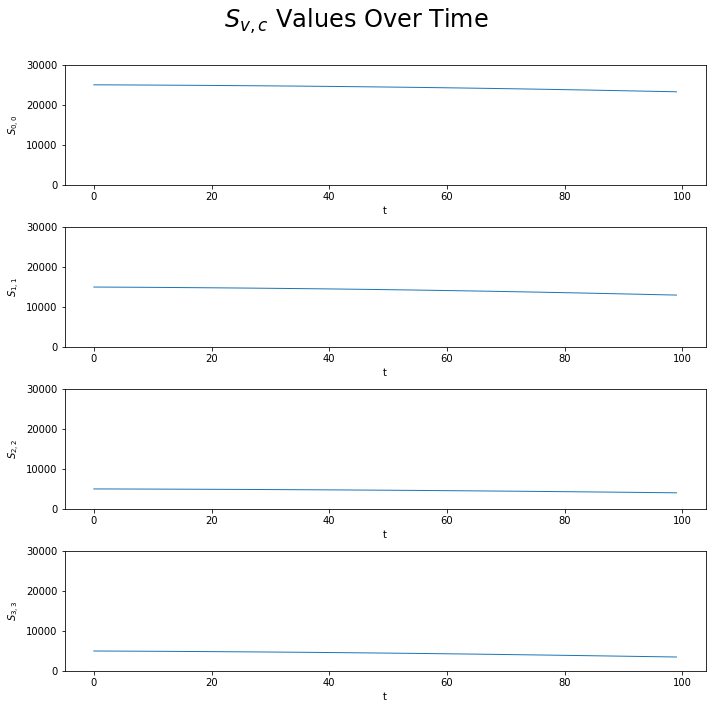

In [202]:
# S_v,c's
plt.figure(figsize=(10,10))

for i in range(0,4):
    
    plt.subplot(4,1, i+1)
    plt.ylim(-10, 30000)
    plt.plot(t, soln_obj.sol(t)[i], linewidth=1)
    plt.xlabel("t")
    plt.ylabel('$S_{{{},{}}}$'.format(i, i)).set_rotation(90)
    

plt.tight_layout()
plt.suptitle('$S_{v,c}$ Values Over Time', fontsize = 24)
plt.subplots_adjust(top=.90)
plt.show()


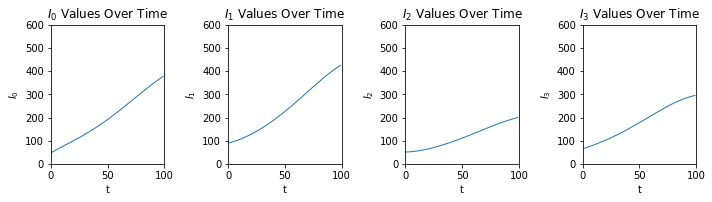

In [203]:
#I_c's over time

plt.figure(figsize=(10,10))

for i in range(0,4):
    
    plt.subplot(4,4, i+1)
    plt.xlim(0, 100)
    plt.ylim(0, 600)
    plt.plot(t, soln_obj.sol(t)[i + 4], linewidth=1)
    plt.xlabel("t")
    plt.ylabel('$I_{}$'.format(i)).set_rotation(90)
    plt.title('$I_{}$ Values Over Time'.format(i))
    
#plt.suptitle('$I_{c}$ Values Over Time', fontsize = 20)
plt.subplots_adjust(top=.2)
plt.tight_layout()
plt.show()


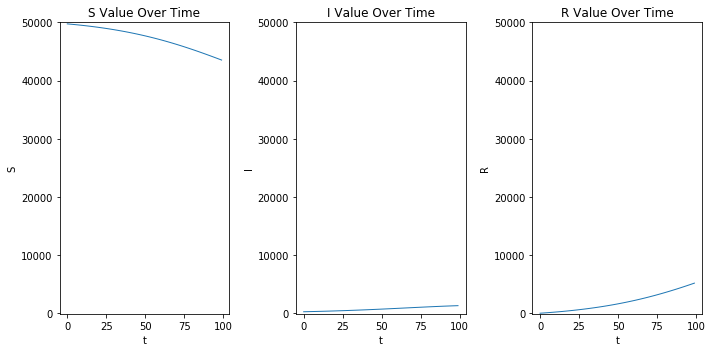

In [204]:
plt.figure(figsize=(10,5))

# S_v,c

plt.subplot(1,3,1)

plt.plot(t, np.sum(soln_obj.sol(t)[0:4], axis = 0), linewidth=1)
plt.xlabel("t")
plt.ylabel("S")
plt.ylim(-100, 50000)
plt.title('S Value Over Time')


plt.subplot(1,3,2)

# I
plt.plot(t, np.sum(soln_obj.sol(t)[4:8], axis = 0), linewidth=1)
plt.xlabel("t")
plt.ylabel("I")
plt.ylim(-100, 50000)
plt.title('I Value Over Time')


plt.subplot(1,3,3)

# R
plt.plot(t, soln_obj.sol(t)[-1], linewidth=1)
plt.xlabel("t")
plt.ylabel("R")
plt.ylim(-100, 50000)
plt.title('R Value Over Time')

plt.tight_layout()
plt.show()

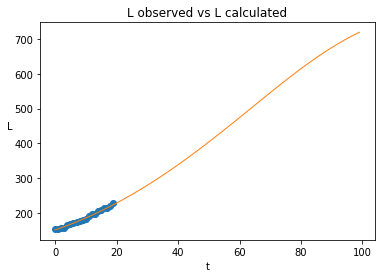

In [206]:
# L
plt.plot(t[0:20], data1b['L_test'][0], linewidth=1, marker='o')
plt.plot(t[0:100], L.reshape(100,1), linewidth=1)
plt.xlabel("t")
plt.ylabel("L").set_rotation(0)
plt.title('L observed vs L calculated')
plt.show()

#### Node 2

In [207]:
t = np.linspace(0,99,100)
N = data1b['N']
betas = np.array([0.2, 0.25, 0.30000000000000004, 0.4])
gamma = data1a['gamma'].reshape(1)[0]
S_0 = N*[0.4,0.3,0.2,0.1]-data1b["Ic_0"][5]
gamma = data1b['gamma'].reshape(1)[0]
initial_vec = (np.concatenate([S_0,data1b['Ic_0'][5].flatten(),R_0]))

In [208]:
# Solving the initial value problem

from scipy.integrate import solve_ivp

soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec, \
                             args = [betas, gamma],\
                             dense_output=True)
solutions = soln_obj.sol(t)

In [209]:
data1b.files
# # Calculate L's
Lc = data1b['Lc']

L = (Lc.reshape(-1,4)@solutions[4:8])

Here we plot all the $S_{v,c}$ and $I_c$ values over time.

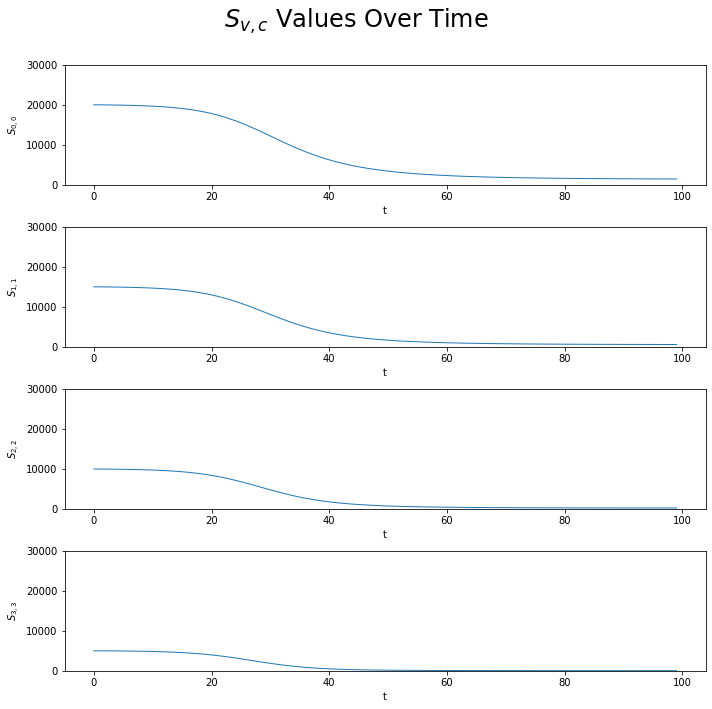

In [210]:
# S_v,c's
plt.figure(figsize=(10,10))

for i in range(0,4):
    
    plt.subplot(4,1, i+1)
    plt.ylim(-10, 30000)
    plt.plot(t, soln_obj.sol(t)[i], linewidth=1)
    plt.xlabel("t")
    plt.ylabel('$S_{{{},{}}}$'.format(i, i)).set_rotation(90)
    

plt.tight_layout()
plt.suptitle('$S_{v,c}$ Values Over Time', fontsize = 24)
plt.subplots_adjust(top=.90)
plt.show()


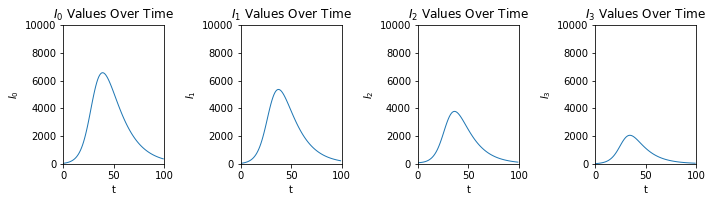

In [211]:
#I_c's over time

plt.figure(figsize=(10,10))

for i in range(0,4):
    
    plt.subplot(4,4, i+1)
    plt.xlim(0, 100)
    plt.ylim(0, 10000)
    plt.plot(t, soln_obj.sol(t)[i + 4], linewidth=1)
    plt.xlabel("t")
    plt.ylabel('$I_{}$'.format(i)).set_rotation(90)
    plt.title('$I_{}$ Values Over Time'.format(i))
    
#plt.suptitle('$I_{c}$ Values Over Time', fontsize = 20)
plt.subplots_adjust(top=.2)
plt.tight_layout()
plt.show()


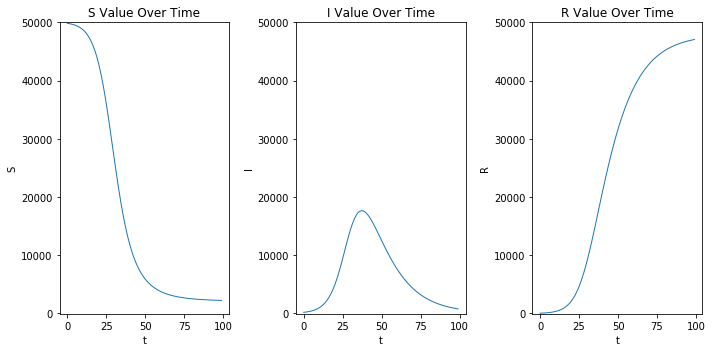

In [212]:
plt.figure(figsize=(10,5))

# S_v,c

plt.subplot(1,3,1)

plt.plot(t, np.sum(soln_obj.sol(t)[0:4], axis = 0), linewidth=1)
plt.xlabel("t")
plt.ylabel("S")
plt.ylim(-100, 50000)
plt.title('S Value Over Time')


plt.subplot(1,3,2)

# I
plt.plot(t, np.sum(soln_obj.sol(t)[4:8], axis = 0), linewidth=1)
plt.xlabel("t")
plt.ylabel("I")
plt.ylim(-100, 50000)
plt.title('I Value Over Time')


plt.subplot(1,3,3)

# R
plt.plot(t, soln_obj.sol(t)[-1], linewidth=1)
plt.xlabel("t")
plt.ylabel("R")
plt.ylim(-100, 50000)
plt.title('R Value Over Time')

plt.tight_layout()
plt.show()

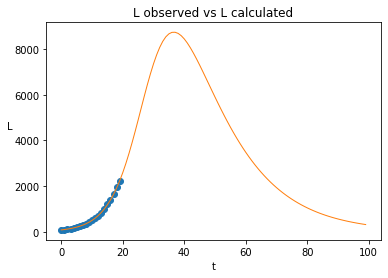

In [213]:
# L
plt.plot(t[0:20], data1b['L_test'][5], linewidth=1, marker='o')
plt.plot(t[0:120], L.reshape(100,1), linewidth=1)
plt.xlabel("t")
plt.ylabel("L").set_rotation(0)
plt.title('L observed vs L calculated')
plt.show()

#### Node 3

In [214]:
N = data1b['N']
betas = np.array([0.4, 0.45, 0.5, 0.6000000000000001])
gamma = data1a['gamma'].reshape(1)[0]
S_0 = N*[0.3,0.3,0.2,0.2]-data1b["Ic_0"][10]
gamma = data1b['gamma'].reshape(1)[0]
initial_vec = (np.concatenate([S_0,data1b['Ic_0'][10].flatten(),R_0]))
print(S_0)

[14924. 14987.  9939.  9985.]


In [215]:
# Solving the initial value problem

from scipy.integrate import solve_ivp

soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec, \
                             args = [betas, gamma],\
                             dense_output=True)
solutions = soln_obj.sol(t)

In [216]:
data1b.files
# # Calculate L's
Lc = data1b['Lc']

L = (Lc.reshape(-1,4)@solutions[4:8])

Here we plot all the $S_{v,c}$ and $I_c$ values over time.

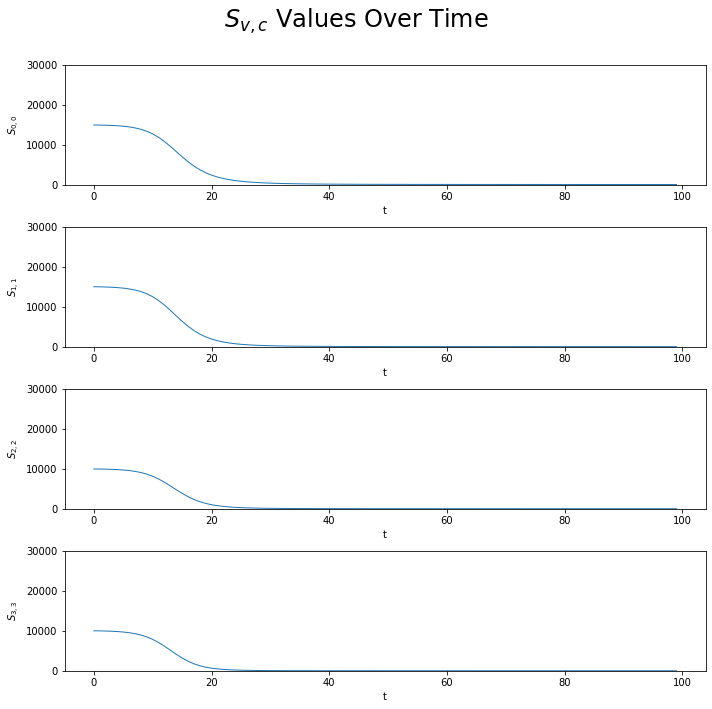

In [217]:
# S_v,c's
plt.figure(figsize=(10,10))

for i in range(0,4):
    
    plt.subplot(4,1, i+1)
    plt.ylim(-10, 30000)
    plt.plot(t, soln_obj.sol(t)[i], linewidth=1)
    plt.xlabel("t")
    plt.ylabel('$S_{{{},{}}}$'.format(i, i)).set_rotation(90)
    

plt.tight_layout()
plt.suptitle('$S_{v,c}$ Values Over Time', fontsize = 24)
plt.subplots_adjust(top=.90)
plt.show()


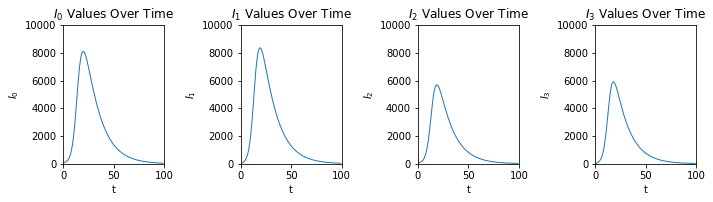

In [218]:
#I_c's over time

plt.figure(figsize=(10,10))

for i in range(0,4):
    
    plt.subplot(4,4, i+1)
    plt.xlim(0, 100)
    plt.ylim(0, 10000)
    plt.plot(t, soln_obj.sol(t)[i + 4], linewidth=1)
    plt.xlabel("t")
    plt.ylabel('$I_{}$'.format(i)).set_rotation(90)
    plt.title('$I_{}$ Values Over Time'.format(i))
    
#plt.suptitle('$I_{c}$ Values Over Time', fontsize = 20)
plt.subplots_adjust(top=.2)
plt.tight_layout()
plt.show()


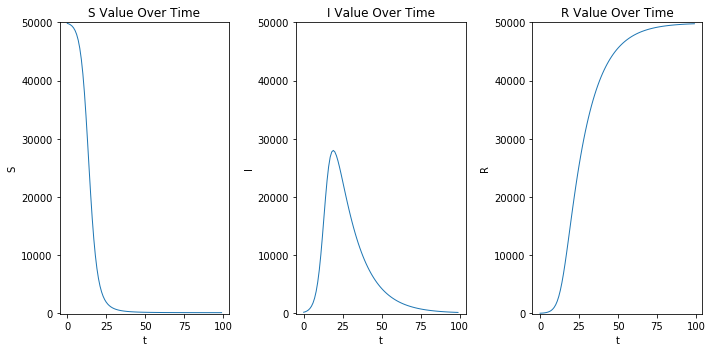

In [219]:
plt.figure(figsize=(10,5))

# S_v,c

plt.subplot(1,3,1)

plt.plot(t, np.sum(soln_obj.sol(t)[0:4], axis = 0), linewidth=1)
plt.xlabel("t")
plt.ylabel("S")
plt.ylim(-100, 50000)
plt.title('S Value Over Time')


plt.subplot(1,3,2)

# I
plt.plot(t, np.sum(soln_obj.sol(t)[4:8], axis = 0), linewidth=1)
plt.xlabel("t")
plt.ylabel("I")
plt.ylim(-100, 50000)
plt.title('I Value Over Time')


plt.subplot(1,3,3)

# R
plt.plot(t, soln_obj.sol(t)[-1], linewidth=1)
plt.xlabel("t")
plt.ylabel("R")
plt.ylim(-100, 50000)
plt.title('R Value Over Time')

plt.tight_layout()
plt.show()

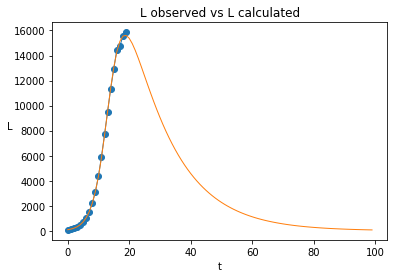

In [221]:
# L
plt.plot(t[0:20], data1b['L_test'][10], linewidth=1, marker='o')
plt.plot(t[0:100], L.reshape(100,1), linewidth=1)
plt.xlabel("t")
plt.ylabel("L").set_rotation(0)
plt.title('L observed vs L calculated')
plt.show()

#### Node 4

In [222]:
N = data1b['N']
betas = np.array([0.35000000000000003, 0.7000000000000001, 0.75, 0.8500000000000001])
gamma = data1a['gamma'].reshape(1)[0]
S_0 = N*[0.1,0.2,0.3,0.4]-data1b["Ic_0"][15]
gamma = data1b['gamma'].reshape(1)[0]
initial_vec = (np.concatenate([S_0,data1b['Ic_0'][15].flatten(),R_0]))
print(S_0)

[ 4975.  9966. 14984. 19972.]


In [223]:
# Solving the initial value problem

from scipy.integrate import solve_ivp

soln_obj=integrate.solve_ivp(SIR_model, (t[0],t[-1]), initial_vec, \
                             args = [betas, gamma],\
                             dense_output=True)
solutions = soln_obj.sol(t)

In [224]:
data1b.files
# # Calculate L's
Lc = data1b['Lc']

L = (Lc.reshape(-1,4)@solutions[4:8])

Here we plot all the $S_{v,c}$ and $I_c$ values over time.

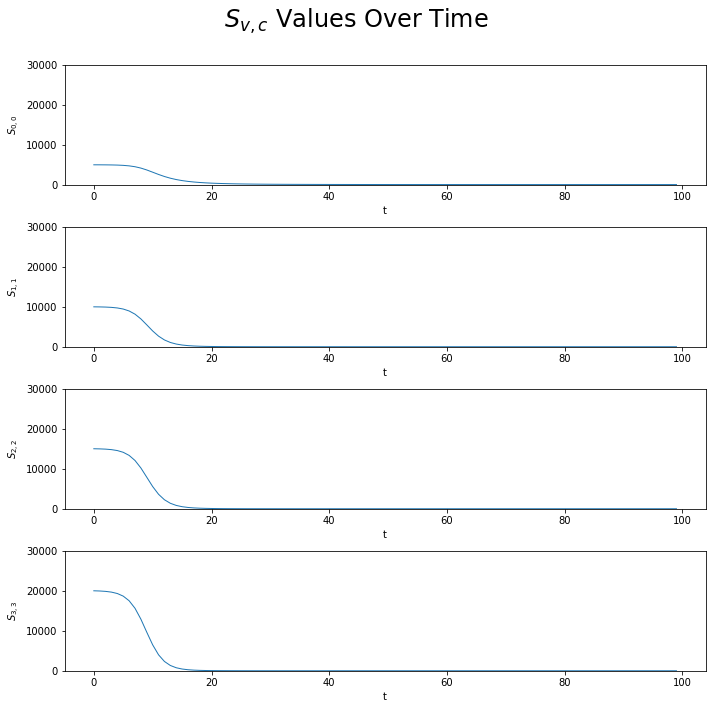

In [225]:
# S_v,c's
plt.figure(figsize=(10,10))

for i in range(0,4):
    
    plt.subplot(4,1, i+1)
    plt.ylim(-10, 30000)
    plt.plot(t, soln_obj.sol(t)[i], linewidth=1)
    plt.xlabel("t")
    plt.ylabel('$S_{{{},{}}}$'.format(i, i)).set_rotation(90)
    

plt.tight_layout()
plt.suptitle('$S_{v,c}$ Values Over Time', fontsize = 24)
plt.subplots_adjust(top=.90)
plt.show()


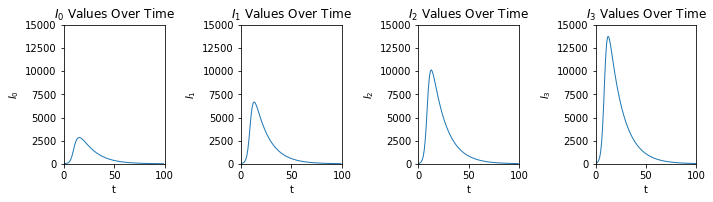

In [226]:
#I_c's over time

plt.figure(figsize=(10,10))

for i in range(0,4):
    
    plt.subplot(4,4, i+1)
    plt.xlim(0, 100)
    plt.ylim(0, 15000)
    plt.plot(t, soln_obj.sol(t)[i + 4], linewidth=1)
    plt.xlabel("t")
    plt.ylabel('$I_{}$'.format(i)).set_rotation(90)
    plt.title('$I_{}$ Values Over Time'.format(i))
    
#plt.suptitle('$I_{c}$ Values Over Time', fontsize = 20)
plt.subplots_adjust(top=.2)
plt.tight_layout()
plt.show()


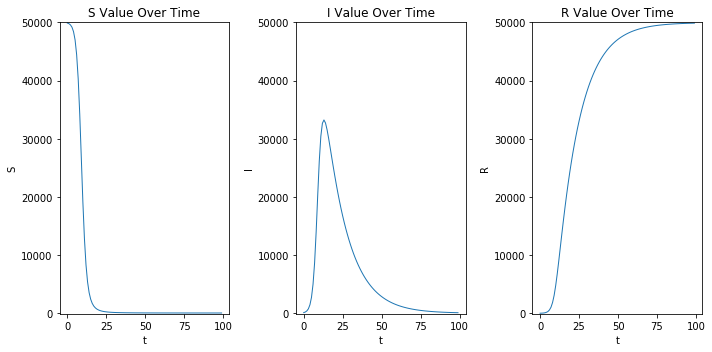

In [227]:
plt.figure(figsize=(10,5))

# S_v,c

plt.subplot(1,3,1)

plt.plot(t, np.sum(soln_obj.sol(t)[0:4], axis = 0), linewidth=1)
plt.xlabel("t")
plt.ylabel("S")
plt.ylim(-100, 50000)
plt.title('S Value Over Time')


plt.subplot(1,3,2)

# I
plt.plot(t, np.sum(soln_obj.sol(t)[4:8], axis = 0), linewidth=1)
plt.xlabel("t")
plt.ylabel("I")
plt.ylim(-100, 50000)
plt.title('I Value Over Time')


plt.subplot(1,3,3)

# R
plt.plot(t, soln_obj.sol(t)[-1], linewidth=1)
plt.xlabel("t")
plt.ylabel("R")
plt.ylim(-100, 50000)
plt.title('R Value Over Time')

plt.tight_layout()
plt.show()

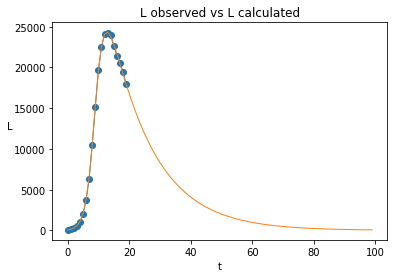

In [228]:
# L
plt.plot(t[0:20], data1b['L_test'][15], linewidth=1, marker='o')
plt.plot(t[0:100], L.reshape(100,1), linewidth=1)
plt.xlabel("t")
plt.ylabel("L").set_rotation(0)
plt.title('L observed vs L calculated')
plt.show()